# Analysis on the C4MIP 1% CO$_2$ increase simulations


## Methodology

- Use the dask to parallelize the processings including global and annual average and summary using NCO toolkit
- Compute the Beta and Gamma for atmosphere, land and ocean
- Plot figures

Inspired by Charlie Koven's Jupyter notebook at his github [repo](https://github.com/ckoven/cesm2_c4mip) 

### Import python packages used in the analysis

In [6]:
import dask
import os, glob
import numpy as np
import netCDF4 as nc4
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

### Define two functuons:
  - rungbl: use a shell script to compute global and annual average and sum
  - analysis: calcuate the beta and gamma from the above results
  - plot_beta_gamma: plot the beta and gamma for atm, lnd and ocn

In [7]:

def plot_beta_gamma(co2_bgc_global_annual, delta_co2, delta_tas, cmp_sink, cmp_name):

    fig, (ax1, ax2) = plt.subplots(1, 2)

    x = co2_bgc_global_annual
    ax1.plot(x, (cmp_sink[2]-cmp_sink[1])/delta_co2)
    ax1.grid(); ax1.set_xlabel('CO2 concentration (ppm)', fontsize=15); ax1.set_ylabel('Beta {} (PgC/ppm)'.format(cmp_name), fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    
    x = delta_tas
    ax2.plot(x, (cmp_sink[3]-cmp_sink[2])/delta_tas)
    ax2.grid(); ax2.set_xlabel('Changes in Tas (\u00B0C)', fontsize=15); ax2.set_ylabel('Gamma {} (PgC/\u00B0C)'.format(cmp_name), fontsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    

In [8]:
def rungbl(argstr):
    
    import re

    
    #os.system("./comp_global_time_series.sh " + argstr)
    varname=(re.findall(r'--variable=\s+(\w+)\s*', argstr) or re.findall(r'-v\s+(\w+)\s*', argstr) or None,)[0][0]
    method=(re.findall(r'--method=\s+(\w+)\s*', argstr) or re.findall(r'-m\s+(\w+)\s*', argstr) or None,)[0][0]
    output=(re.findall(r'--output=\s+(\w+)\s*', argstr) or re.findall(r'-o\s+(\w+)\s*', argstr) or None,)[0][0]
    
    if varname and output:
        if not os.path.isdir(output):
            os.system("mkdir -p "+output)
        return output+'/'+method+'_'+varname
    else:
        raise ValueError

        
def analysis(tasks):   

    colors=['r', 'k', 'g', 'b']
    
    for task in tasks:
        if 'nbp' in task:
            output=task.split('/')[0]
            nbpname=task.split('/')[1]
            nbpfiles=glob.glob(output+"/*nbp_*.nc")
            nbpfiles.sort(reverse=True)      
        if 'tas' in task:
            output=task.split('/')[0]
            tasname=task.split('/')[1]
            tasfiles=glob.glob(output+"/*tas_*.nc")
            tasfiles.sort(reverse=True)
        if 'fgco2' in task:
            output=task.split('/')[0]
            fgco2name=task.split('/')[1]
            fgco2files=glob.glob(output+"/*fgco2*.nc")
            fgco2files.sort(reverse=True)

    with nc4.Dataset("GHG_CMIP6_1pctCO2_c20180216.nc", 'r') as ncf:
        co2=ncf.variables['CO2'][0:150]

    
    #co2_1850 = 284.7  ## CESM used the CMIP5 rather than the CMIP6 value
    co2_1850 = co2[0]
    co2_bgc_global_annual = co2
    co2_ful_global_annual = co2
    
    #co2_bgc_global_annual = co2_1850 * 1.01 ** np.arange(150)
    #co2_ful_global_annual = co2_1850 * 1.01 ** np.arange(150)
    co2_ctl_global_annual = co2_1850 * 1.00 ** np.arange(150)
    co2_rad_global_annual = co2_1850 * 1.00 ** np.arange(150)

    delta_co2 = co2_bgc_global_annual - co2_ctl_global_annual[0:150]

    tas_list=[]
    atm_sink=[]
    lnd_sink=[]
    ocn_sink=[]

    x=np.linspace(1, 150, 150)
    for ic, file in enumerate(nbpfiles):
        with nc4.Dataset(file, 'r') as ncf1, \
            nc4.Dataset(fgco2files[ic],'r') as ncf2, \
            nc4.Dataset(tasfiles[ic], 'r') as ncf3:
            nbp = ncf1.variables[nbpname][0:150]
            fgco2 = ncf2.variables[fgco2name][0:150]
            tas_list.append(ncf3.variables[tasname][0:150])
            atm_sink.append(-(nbp+fgco2).cumsum())
            lnd_sink.append(nbp.cumsum())
            ocn_sink.append(fgco2.cumsum())
    #plt.plot(x, nbp, color=colors[ic])
    delta_tas = tas_list[3] - tas_list[1]    
    
    plot_beta_gamma(co2_bgc_global_annual, delta_co2, delta_tas, atm_sink, 'atm')
    plot_beta_gamma(co2_bgc_global_annual, delta_co2, delta_tas, lnd_sink, 'lnd')
    plot_beta_gamma(co2_bgc_global_annual, delta_co2, delta_tas, ocn_sink, 'ocn')

### Apply the dask parallelism and get the analysis results

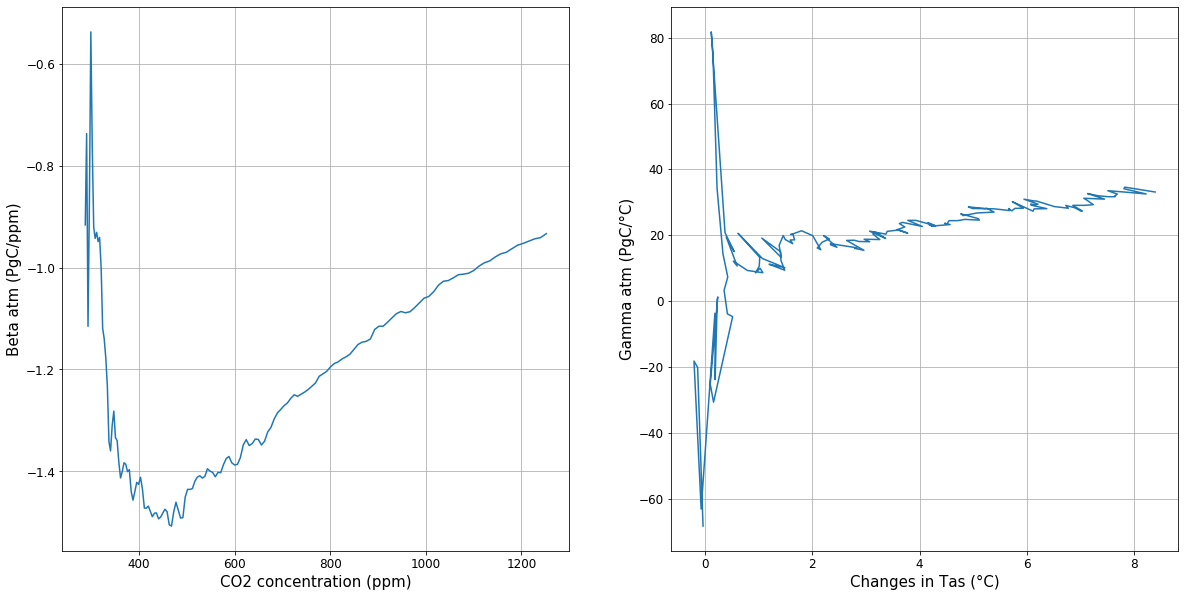

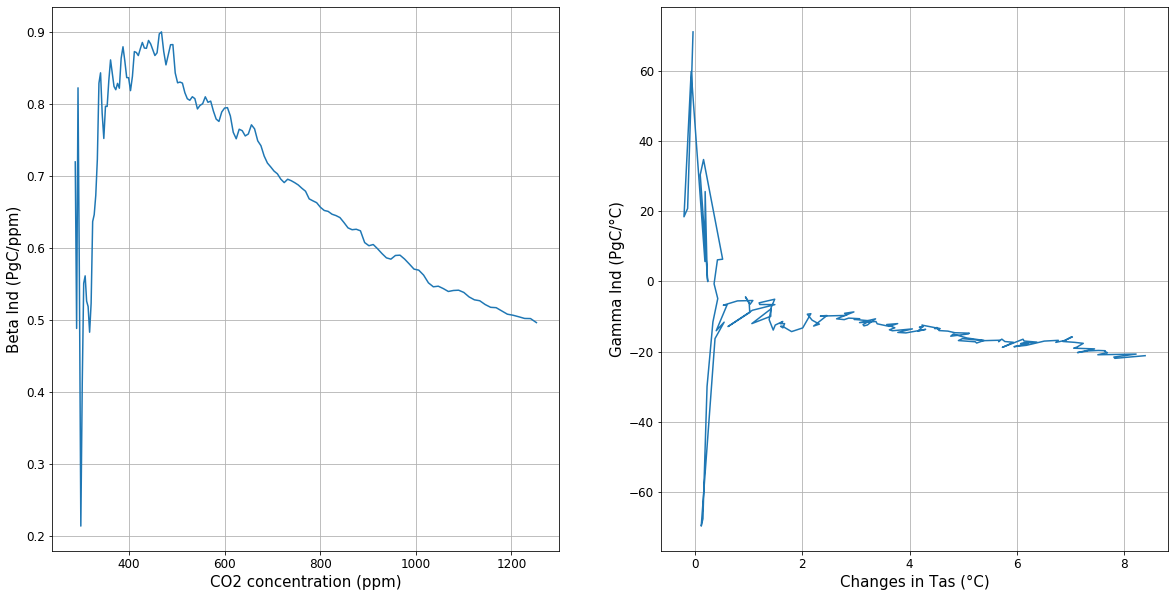

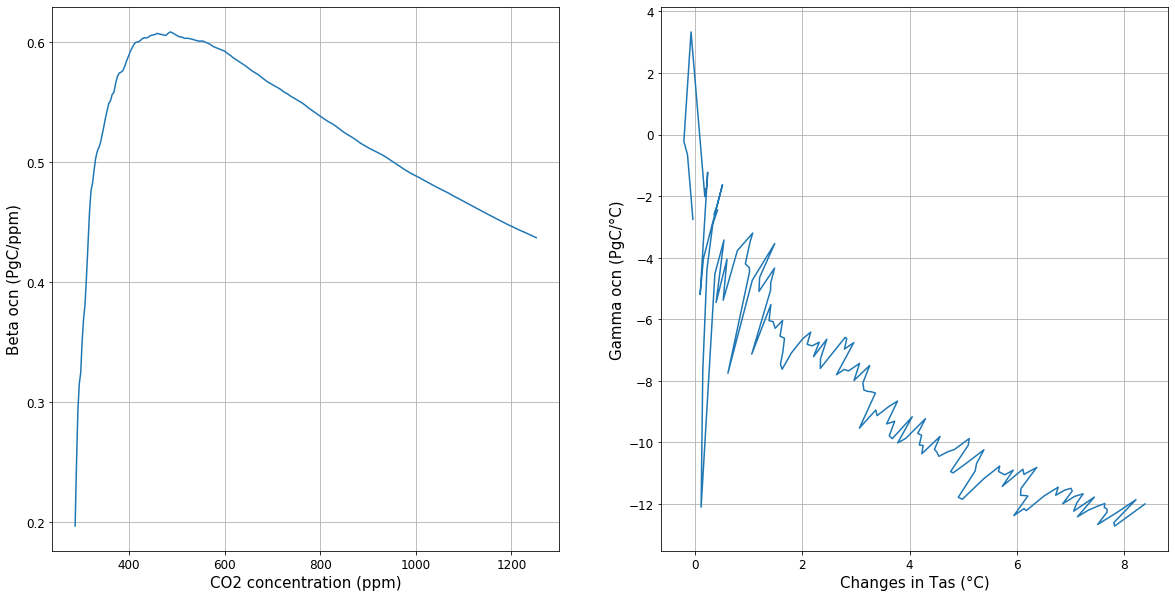

In [9]:

argstrs = ["-b ../data -o e3sm/ -v tas -c Amon -m ga2aa   --modnam=e3sm --Gfactor=-273.15 --itype=mip", \
           "-b ../data -o e3sm/ -v nbp -c Lmon -m gs1as   --modnam=e3sm --Gscale=1.e-12 --Ascale=86400. --itype=mip", \
           "-b ../data -o e3sm/ -v gpp -c Lmon -m gs1as   --modnam=e3sm --Gscale=1.e-12 --Ascale=86400. --itype=mip", \
           "-b ../data -o e3sm/ -v npp -c Lmon -m gs1as   --modnam=e3sm --Gscale=1.e-12 --Ascale=86400. --itype=mip", \
           "-b ../data -o e3sm/ -v fgco2 -c Omon -m gs1as --modnam=e3sm --Gscale=1.e-12 --Ascale=86400.0 --itype=mip"]
tasks=[]
for argstr in argstrs:
    tasks.append(dask.delayed(rungbl)(argstr))

z = dask.delayed(analysis)(tasks)
z.compute()